# 라이브러리 로드 

In [2]:
from geoband.API import *
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import json
import shapefile

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
acci_info = gpd.read_file('./data/1.대전광역시_교통사고내역(2017~2019).csv') # 교통사고 내역
acci_grid = gpd.read_file('./data/2.대전광역시_교통사고격자(2017~2019).geojson') # 교통사고 격자

### 격자 전용 데이터프레임

In [5]:
grid = acci_grid[['gid', 'geometry']]

### 격자 데이터로 shp 파일 생성

In [ ]:
# multipolygon to polygon

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def explode(indata):
    indf = indata
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

grid2 = explode(grid)
grid2.to_file("polygon_grid.geojson", driver='GeoJSON') # save

In [ ]:
# geojson to shape


# The json module is needed to load the geoJSON file
# The shapefile, from pyshp, is needed to construct the shapefile object
class GeoJ:
    geometryType = ''
    columnsList = []
    __attributesPerF = []
    attributes = []
    geometries = []
    shpFileObj = None
    
    # The constructor which basically needs the geoJSON file+path as an argument
    def __init__(self, geoJFile):
        # This try statement makes sure that the geojson file exists and it is in JSON structure
        try:
            self.geoJFile = open(geoJFile)
        except IOError:
            print("Error: can not find file. Make sure the file name and path are correct")
        else:
            try:
                self.geoJObj = json.load(self.geoJFile)
            except ValueError:
                print("Error: the file is not in JSON structure")
            else:
                # If everything is fine, the __parseGeoJ private method will 
                # collect attributes and geometries from the geoJSON file
                self.__parseGeoJ()

    def __parseGeoJ(self):

        self.geometryType = self.geoJObj['features'][0]['geometry']['type']

        self.columnsList = self.geoJObj['features'][0]['properties'].keys()

        for i in self.geoJObj['features']:

            if i['geometry']['type'] == self.geometryType:
                self.geometries.append(i['geometry']['coordinates'])
                for j in self.columnsList:
                    self.__attributesPerF.append(str(i['properties'][str(j)]))
                self.attributes.append(self.__attributesPerF)
                self.__attributesPerF = []

    # This method along with the following private methods will create a shapefile
    # from the collected attributes and geometries from the geoJSON file
    def toShp(self, shpFile):

        if self.geometryType == 'Point':
            self.__createPoint()
        elif self.geometryType == 'LineString':
            self.__createLine()
        elif self.geometryType == 'Polygon':
            self.__createPolygon()
        else:
            print('Can not proceed. The geometry type ' + self.geometryType + ' is not supported in this program')
            return

        # Calling the __createPrjFile method to create a .prj file
        self.__createPrjFile(shpFile)

        # Saving the shape file, which creates .shp, .shx, and .dbf files
        self.shpFileObj.save(shpFile)

    # This method is used to create points shapefile
    def __createPoint(self):

        self.shpFileObj = shapefile.Writer(shapefile.POINT)
        self.shpFileObj.autoBalance = 1
        self.__createColumns()

        for i in self.geometries:
            self.shpFileObj.point(i[0],i[1])

        for j in self.attributes:
            self.shpFileObj.record(*j)
    
    # This method is used to create lines shapefile
    def __createLine(self):

        self.shpFileObj = shapefile.Writer(shapefile.POLYLINE)
        self.shpFileObj.autoBalance = 1
        self.__createColumns()

        for i in self.geometries:
            self.shpFileObj.line(parts=[i])

        for j in self.attributes:
            self.shpFileObj.record(*j)

    # This method is used to create polygons shapefile
    def __createPolygon(self):

        self.shpFileObj = shapefile.Writer(shapefile.POLYGON)
        self.shpFileObj.autoBalance = 1
        self.__createColumns()

        for i in self.geometries:
            self.shpFileObj.poly(parts=i)

        for j in self.attributes:
            self.shpFileObj.record(*j)

    # This method is used to create the columns names read from the geoJSON file
    def __createColumns(self):

        for i in self.columnsList:
            # Field names cannot be unicode.
            # That is why I cast it to string.
            self.shpFileObj.field(str(i), 'C', '50')

    # This method currently creates a .prj file with WGS84 projection
    def __createPrjFile(self, shpFile):

        prjFile = open( shpFile + '.prj', 'w')
        prjStr = 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]'
        prjFile.write(prjStr)
        prjFile.close()

##########################
#      running main      #
##########################

if __name__ == '__main__':

    # Create an object from the GeoJ class
    gJ = GeoJ('./polygon_grid.geojson')
    
    # Creating a shapefile from the geoJSON object
    gJ.toShp('./grid.shp')


# 1. 보행, 차량 신호등 개수
* point 좌표

In [6]:
sg_walk = gpd.read_file('./data/3.대전광역시_신호등(보행등).geojson') # 보행신호등 7407개
sg_car = gpd.read_file('./data/4.대전광역시_신호등(차량등).geojson') # 차량신호등 11998개

### 보행 신호등

In [7]:
# 격자데이터가 신호등 좌표를 포함하도록 join 
sg_walk = sg_walk[['geometry']]
result1 = gpd.sjoin(grid, sg_walk, how='left', op='intersects')

# index번호가 있는 것은 1로, 아닌 것은 0으로 채움
result1.loc[result1["index_right"] >= 0, 'index_right'] = 1
result1['index_right'].fillna(0, inplace=True)

# 같은 gid와 geomtry를 가진 것끼리 더해서 갯수를 구함
result1 = result1.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
result1.rename({'index_right':'sg_walk_cnt'}, axis=1, inplace=True)

print('보행 신호등 총합:', result1['sg_walk_cnt'].sum())

보행 신호등 총합: 7406.0


### 차량 신호등

In [8]:
sg_car = sg_car[['geometry']]
result2 = gpd.sjoin(grid, sg_car, how='left', op='intersects')

result2.loc[result2["index_right"] >= 0, 'index_right'] = 1
result2['index_right'].fillna(0, inplace=True)

result2 = result2.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
result2.rename({'index_right':'sg_car_cnt'}, axis=1, inplace=True)

print('차량 신호등 총합:', result2['sg_car_cnt'].sum())

차량 신호등 총합: 11995.0


In [9]:
result2 = result2[['gid', 'sg_car_cnt']]
result2 = pd.merge(result1, result2, how='left', on='gid')

# 2. 안전지대 개수
* multipolygon

In [10]:
safe_zn = gpd.read_file('./data/5.대전광역시_안전지대.geojson') #3026

In [11]:
safe_zn = safe_zn[['geometry']]
temp = gpd.sjoin(grid, safe_zn, how='left', op='intersects')

In [12]:
temp.loc[temp["index_right"] >= 0, 'index_right'] = 1
temp['index_right'].fillna(0, inplace=True)

temp = temp.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
temp.rename({'index_right':'safe_zn_cnt'}, axis=1, inplace=True)

temp = temp[['gid', 'safe_zn_cnt']]

print('안전지대 총합:', temp['safe_zn_cnt'].sum())

안전지대 총합: 4211.0


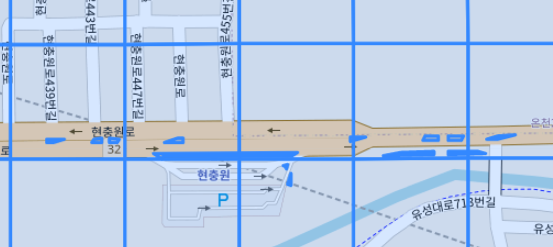

 multipolygon 형태로 된 데이터의 경우, 위와 같이 격자 위에 걸쳐질 떄 격자별로 갯수가 중복 count됨을 유의

In [13]:
result3 = pd.merge(result2, temp, how='left', on='gid')

# 3. 횡단보도 개수
* multipolygon

In [14]:
cross = gpd.read_file('./data/6.대전광역시_횡단보도.geojson') # 12589

In [15]:
cross = cross[['geometry']]
temp = gpd.sjoin(grid, cross, how='left', op='intersects')

temp.loc[temp["index_right"] >= 0, 'index_right'] = 1
temp['index_right'].fillna(0, inplace=True)

temp = temp.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
temp.rename({'index_right':'cro_cnt'}, axis=1, inplace=True)

temp = temp[['gid', 'cro_cnt']]

print('횡단보도 총합:', temp['cro_cnt'].sum())

횡단보도 총합: 15208.0


In [16]:
result4 = pd.merge(result3, temp, how='left', on='gid')

# 4. 도로속도표지
* point 좌표
* 한 격자 안에 제한속도가 다른 경우 고려

In [17]:
spd_sign = gpd.read_file('./data/7.대전광역시_도로속도표시.geojson') # 6799

### 4. 1. 도로속도표지의 개수

In [18]:
# 개수
spd_sign_count = spd_sign[['geometry']]
temp = gpd.sjoin(grid, spd_sign_count, how='left', op='intersects')

temp.loc[temp["index_right"] >= 0, 'index_right'] = 1
temp['index_right'].fillna(0, inplace=True)

temp = temp.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
temp.rename({'index_right':'spd_sign_cnt'}, axis=1, inplace=True)

temp = temp[['gid', 'spd_sign_cnt']]

print('속도표지 총합:', temp['spd_sign_cnt'].sum())

속도표지 총합: 6798.0


### 4. 2. 도로속도표지에 명시된 제한속도

In [19]:
spd_sign_char = spd_sign[['geometry', 'char_ctt']]
temp_char = gpd.sjoin(grid, spd_sign_char, how='left', op='intersects')
temp_char = temp_char[['gid', 'geometry', 'char_ctt']]

In [20]:
temp_char[temp_char['char_ctt']=='70m']
temp_char.loc[temp_char["char_ctt"] == '70m', 'char_ctt'] = 70
temp_char['char_ctt'] = pd.to_numeric(temp_char['char_ctt'])

In [21]:
# 격자별로 최대값에서 최솟값 빼서 속도 차이 계산

def mydef(x):
    return x['char_ctt'].max() - x['char_ctt'].min()

test = temp_char.groupby(['gid', 'geometry'], as_index = False, sort=False).apply(mydef)
test.columns = ['gid', 'geometry', 'spd_diff']

In [22]:
print(test['spd_diff'].unique())
spd_diff = test[(test['spd_diff'] == 10) | (test['spd_diff'] == 20) | (test['spd_diff'] == 30) | (test['spd_diff'] == 50)]
spd_diff = spd_diff[['gid', 'spd_diff']]

[nan  0. 20. 10. 50. 30.]


In [23]:
result5 = pd.merge(result4, temp,  how='left', on='gid')
result5 = pd.merge(result5, spd_diff,  how='left', on='gid')
result5['spd_diff'].fillna(0, inplace=True)

### 4.3. 도로속도표지의 유무(0 or 1)

In [24]:
# 표지 유무
result5.loc[result5["spd_sign_cnt"] >= 1, 'spd_sign'] = 1
result5['spd_sign'].fillna(0, inplace=True)

# 5. 정차금지지대 개수
* multipolygon

In [25]:
pull_over = gpd.read_file('./data/8.대전광역시_정차금지지대.geojson') # 46개

In [26]:
pull_over = pull_over[['geometry']]
temp = gpd.sjoin(grid, pull_over, how='left', op='intersects')

temp.loc[temp["index_right"] >= 0, 'index_right'] = 1
temp['index_right'].fillna(0, inplace=True)

temp = temp.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
temp.rename({'index_right':'pull_over_cnt'}, axis=1, inplace=True)

temp = temp[['gid', 'pull_over_cnt']]

print('정차금지지대 총합:', temp['pull_over_cnt'].sum())

정차금지지대 총합: 64.0


In [27]:
result6 = pd.merge(result5, temp, how='left', on='gid')

# 6. 교통안전표지
* point 좌표

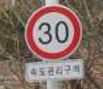

In [28]:
safe_sign = gpd.read_file('./data/9.대전광역시_교통안전표지.geojson') # 37606개
check = safe_sign[['sign_ctt_f', 'sign_ctt_s', 'sign_ctt_t']]
check['sign_ctt_t'].unique()

array([None, '길없음', '불법주정차특별관리구역', '여기서부터 30m', '600*600', '시간제 주차 허용',
       '점심시간 주차허용', '단,주말·공휴일제외', '합류주의', '점심시간주차허용', '100m', '400m',
       '180m. 시간제 주차허용', '150m. 시간제 주차허용', '160m. 시간제 주차허용', '시간제 주차허용',
       '허용시간외 견인지역', '300m. 시간제 주차허용', '800m', '심야시간 주차허용', '심야시간 주차 허용',
       '07:30-21:00', '1.5톤 이하 화물차 허용', '점심시간 주차 허용', '우회전금지'],
      dtype=object)

# 7. 교통CCTV 개수
* point 좌표

In [29]:
cctv = gpd.read_file('./data/10.대전광역시_교통CCTV.geojson') # 132개

In [30]:
cctv = cctv[['geometry']]
temp = gpd.sjoin(grid, cctv, how='left', op='intersects')

temp.loc[temp["index_right"] >= 0, 'index_right'] = 1
temp['index_right'].fillna(0, inplace=True)

temp = temp.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
temp.rename({'index_right':'cctv_cnt'}, axis=1, inplace=True)

temp = temp[['gid', 'cctv_cnt']]

print('CCTV 총합:', temp['cctv_cnt'].sum())

CCTV 총합: 132.0


In [31]:
result7 = pd.merge(result6, temp, how='left', on='gid')

# 8. 인구수
* 격자별 인구
* 사람 없는 격자는 최소 43803개

In [32]:
all_people = gpd.read_file('./data/12.대전광역시_인구정보(총인구).geojson') # 1462724

In [33]:
all_people = all_people[['gid', 'val']]
temp = pd.merge(result7, all_people, on='gid')
temp['val'].fillna(0, inplace=True)
temp.rename({'val':'pop'}, axis=1, inplace=True)

In [34]:
result8 = temp

# 9. 격자별 인구수 대비 고령인, 유소년 인구 비율

In [35]:
all_pop = gpd.read_file('./data/12.대전광역시_인구정보(총인구).geojson') # 1462724
old_pop = gpd.read_file('./data/13.대전광역시_인구정보(고령).geojson') # 225980
kid_pop = gpd.read_file('./data/15.대전광역시_인구정보(유소년).geojson') # 160152

In [36]:
all_pop = all_pop[['gid', 'val']]
all_pop.rename({'val':'all_pop'}, axis=1, inplace=True)

old_pop = old_pop[['gid', 'val']]
old_pop.rename({'val':'old_pop'}, axis=1, inplace=True)

kid_pop = kid_pop[['gid', 'val']]
kid_pop.rename({'val':'kid_pop'}, axis=1, inplace=True)

In [37]:
temp = pd.merge(all_pop, old_pop, on='gid')
temp = pd.merge(temp, kid_pop, on='gid')

In [38]:
# 사람이 있는 곳
temp.dropna(axis=0, inplace=True)
no_people = temp[temp['all_pop'] == 0].index
temp = temp.drop(no_people)

In [39]:
temp['old_pro'] = temp['old_pop']/temp['all_pop'] * 100
temp['kid_pro'] = temp['kid_pop']/temp['all_pop'] * 100
temp = temp[['gid', 'old_pro', 'kid_pro']]

In [40]:
temp

,gid,old_pro,kid_pro
202,다바776100,43.478261,0.0
214,다바777097,0.000000,0.0
216,다바777099,69.230769,0.0
217,다바777100,37.500000,0.0
218,다바777101,0.000000,0.0
...,...,...,...
52431,라바000177,35.483871,0.0
52545,라바001182,0.000000,0.0
52642,라바002186,0.000000,0.0
52643,라바002187,46.153846,0.0


In [41]:
result9 = pd.merge(result8, temp, how='left', on='gid')
result9['old_pro'].fillna(0, inplace=True)
result9['kid_pro'].fillna(0, inplace=True)

# 10. 도로명주소(건물)

In [42]:
building = gpd.read_file('./data/23.대전광역시_도로명주소(건물).geojson')
building['CATEGORY'] = building.BDTYP_CD.str[:2]
building_08 = building[building['CATEGORY'] == '08']

## 10.1. 유소년 관련 건물
* 08101 초등학교
* 08102 중학교
* 08103 고등학교
* 08201 유치원
* 08202 영유아보육시설
* 08003 어린이집
* 08204 아동복지시설
* 08299 기타아동관련시설

In [43]:
building_kid = building[(building['BDTYP_CD'] == '08101')| (building['BDTYP_CD'] == '08102') | 
         (building['BDTYP_CD'] == '08103') | (building['BDTYP_CD'] == '08201') |
         (building['BDTYP_CD'] == '08202') | (building['BDTYP_CD'] == '08003') | 
         (building['BDTYP_CD'] == '08204') | (building['BDTYP_CD'] == '08299')
]

In [44]:
building_kid = building_kid[['geometry']]
temp = gpd.sjoin(grid, building_kid, how='left', op='intersects')

temp.loc[temp["index_right"] >= 0, 'index_right'] = 1
temp['index_right'].fillna(0, inplace=True)

temp = temp.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
temp.rename({'index_right':'building_kid_cnt'}, axis=1, inplace=True)

temp = temp[['gid', 'building_kid_cnt']]

print('유소년 시설 총합:', temp['building_kid_cnt'].sum())

유소년 시설 총합: 2320.0


In [45]:
result10 = pd.merge(result9, temp, how='left', on='gid')

## 10.2. 노인 관련 건물
* 08300 노인복지시설

In [46]:
building_old = building[building['BDTYP_CD'] == '08300']

In [47]:
building_old = building_old[['geometry']]
temp = gpd.sjoin(grid, building_old, how='left', op='intersects')

temp.loc[temp["index_right"] >= 0, 'index_right'] = 1
temp['index_right'].fillna(0, inplace=True)

temp = temp.groupby(['gid', 'geometry'], as_index = False, sort=False).sum()
temp.rename({'index_right':'building_old_cnt'}, axis=1, inplace=True)

temp = temp[['gid', 'building_old_cnt']]

print('노인 시설 총합:', temp['building_old_cnt'].sum())

노인 시설 총합: 446.0


In [48]:
result10 = pd.merge(result10, temp, how='left', on='gid')

------------------------------

# 교통사고 횟수(종속변수)

* 합차기 전 최종 데이터를 'result'로 설정할 것


In [49]:
result = result10.copy()

## 전체 교통사고(23647건)

In [50]:
acci_grid = acci_grid[['gid', 'acci_cnt']]
result = pd.merge(result, acci_grid, how='left', on='gid')

## 1. 차-차 교통사고(18965건)

In [51]:
acci_car = acci_info[acci_info['피해운전자 차종'] !='보행자']
acci_car.reset_index(inplace=True)
acci_car['acci_car_cnt'] = 1
acci_car = acci_car[['gid', 'acci_car_cnt']]

In [52]:
acci_car = acci_car.groupby(['gid'], as_index = False, sort=False).sum()
result = pd.merge(result, acci_car, how='left', on='gid')
result['acci_car_cnt'].fillna(0, inplace=True)

## 2. 개인형이동수단(PM) 교통사고(123건)

In [53]:
acci_pm = acci_info[(acci_info['피해운전자 차종'] =='개인형이동수단(PM)') | (acci_info['가해운전자 차종'] =='개인형이동수단(PM)')]
acci_pm['acci_pm_cnt'] = 1
acci_pm = acci_pm[['gid', 'acci_pm_cnt']]
acci_pm = acci_pm.groupby(['gid'], as_index = False, sort=False).sum()

In [54]:
result = pd.merge(result, acci_pm, how='left', on='gid')
result['acci_pm_cnt'].fillna(0, inplace=True)

## 3. 차-사람 교통사고

### 3. 1. 유소년 피해자(678건)

In [55]:
acci_walk = acci_info[acci_info['피해운전자 차종']=='보행자']
acci_walk_kid = acci_walk[(acci_walk['피해운전자 연령대'] == '10대미만') | (acci_walk['피해운전자 연령대']=='10대')]
acci_walk_kid['acci_kid_cnt'] = 1
acci_walk_kid = acci_walk_kid[['gid', 'acci_kid_cnt']]
acci_walk_kid = acci_walk_kid.groupby(['gid'], as_index = False, sort=False).sum() 

In [56]:
result = pd.merge(result, acci_walk_kid, how='left', on='gid')
result['acci_kid_cnt'].fillna(0, inplace=True)

### 3.2. 노인 피해자(1420건)

In [57]:
acci_walk_old = acci_walk[(acci_walk['피해운전자 연령대'] == '60대')| (acci_walk['피해운전자 연령대']=='70대') |(acci_walk['피해운전자 연령대']=='80대')|(acci_walk['피해운전자 연령대']=='90대')  ]
acci_walk_old['acci_old_cnt'] = 1
acci_walk_old = acci_walk_old[['gid', 'acci_old_cnt']]

In [58]:
acci_walk_old = acci_walk_old.groupby(['gid'], as_index = False, sort=False).sum() 

In [59]:
result = pd.merge(result, acci_walk_old, how='left', on='gid')
result['acci_old_cnt'].fillna(0, inplace=True)

In [60]:
result.to_file("result.geojson", driver='GeoJSON') # 전처리 파일 저장

# 변수명 정리
## 독립변수
* sg_walk_cnt 보행 신호등 개수
* sg_car_cnt 차량 신호등 개수
* safe_zn_cnt 안전 지대 개수
* cro_cnt 횡단보도 개수
* spd_sign_cnt 속도 표지 개수
* spd_sign 속도 표지 유무
* spd_diff 격자내 속도 표지 차이
* pull_over_cnt 정차 금지 지대 개수
* cctv_cnt CCTV 개수
* pop 격자내 인구수
* kid_pro 유소년 인구 비율
* old_pro 노인 인구비율
* building_kid_cnt 유소년 관련 건물 개수
* building_old_cnt 노인 관련 건물 개수


## 종속변수
* acci_cnt 전체 교통사고
* acci_car_cnt 차대차 교통사고
* acci_pm_cnt 개인형이동수단 교통사고
* acci_kid_cnt 유소년 피해자 교통사고
* acci_old_cnt 노인 피해자 교통사고